In [1]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [3]:
def get_preds(model, tokenizer, dset, text_to_append='', temp_scaling=None):
    text = tokenizer([f'{text_to_append} {x}' for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False)
    predictions = np.array([])
    actual = np.array([])
    probs = np.array([])
    for image, labels in tqdm(dataloader, total=len(dset) // batch_size):
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image.to(device))
            if temp_scaling is not None:
                image_features = torch.div(image_features, temp_scaling)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        vals, indics = text_probs.max(dim=1)
        predictions = np.append(predictions, indics.cpu().numpy())
        actual = np.append(actual, labels.numpy())
        probs = np.append(probs, vals.cpu().numpy())
    return predictions, actual, probs

In [4]:
def calc_bins(y_true, preds, confs, num_bins=10):
  # Assign each prediction to a bin
  bins = np.linspace(1.0 / num_bins, 1, num_bins)
  binned = np.digitize(confs, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = np.mean(y_true[binned==bin] == preds[binned == bin])
      bin_confs[bin] = np.mean(confs[binned==bin])

  return bins, binned, bin_accs, bin_confs, bin_sizes

In [5]:
def get_metrics(y_true, preds, confs):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [6]:
def draw_reliability_graph(y_true, preds, confs, title=None):
  overall_acc = np.mean(y_true == preds)
  ECE, MCE = get_metrics(y_true, preds, confs)
  bins, _, bin_accs, _, _ = calc_bins(y_true, preds, confs)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
  plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
  if title is not None:
    plt.title(title)

Files already downloaded and verified


157it [00:22,  6.93it/s]                         


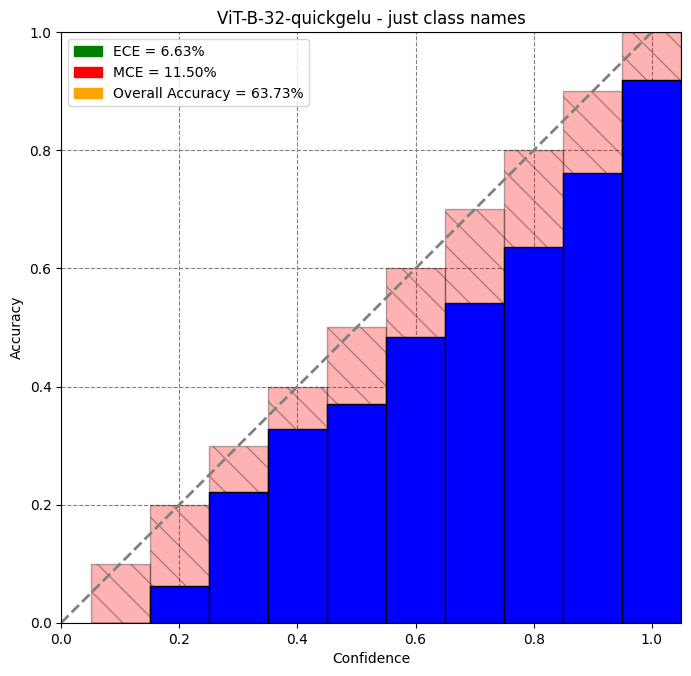

In [7]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
draw_reliability_graph(actual, predictions, probs, f"{model_name} - just class names")

In [7]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

In [8]:
def get_val_set(val_transform):
    cifar_train = datasets.CIFAR100('/home/ubuntu/data/', train = True, transform = val_transform, download=True)
    np.random.seed(0)
    cifar_val = (torch.utils.data.Subset(cifar_train, np.random.randint(0, len(cifar_train), 10000)))
    return cifar_val
cifar_val = get_val_set(preprocess)

NameError: name 'preprocess' is not defined

In [9]:
def find_temp_scale(model, val_dset, show_loss=False):
  temperature = nn.Parameter(torch.ones(1).cuda())
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

  logits_list = []
  labels_list = []
  temps = []
  losses = []

  val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)
  for i, data in enumerate(tqdm(val_loader, 0)):
      images, labels = data[0].to(device), data[1].to(device)

      model.eval()
      with torch.no_grad():
        image_features = model.encode_image(images)
        #image_features /= image_features.norm(dim=-1, keepdim=True)
        logits_list.append(image_features)
        labels_list.append(labels)

  # Create tensors
  logits_list = torch.cat(logits_list).to(device)
  labels_list = torch.cat(labels_list).to(device)

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)

  #print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

  if show_loss:
    plt.subplot(121)
    plt.plot(list(range(len(temps))), temps)

    plt.subplot(122)
    plt.plot(list(range(len(losses))), [x.item() for x in losses])
    plt.show()
  return temperature.item()

100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


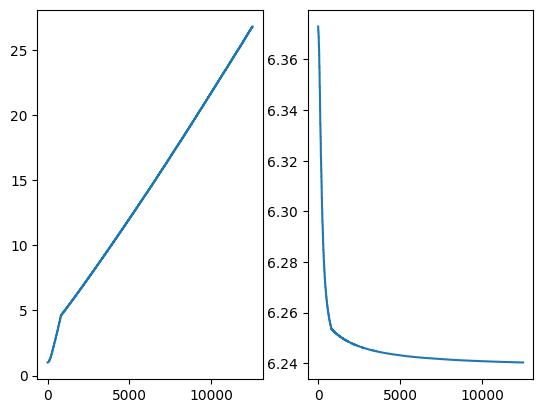

In [28]:
scaled_temp = find_temp_scale(model, cifar_val, show_loss=True)

157it [00:21,  7.40it/s]                         


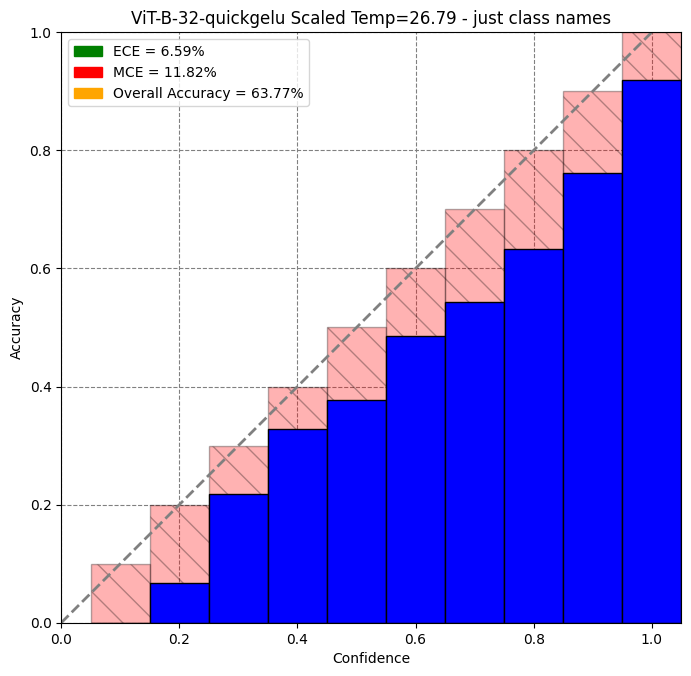

In [31]:
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='', temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - just class names")

157it [00:20,  7.74it/s]                         
100%|██████████| 157/157 [00:18<00:00,  8.26it/s]
157it [00:21,  7.39it/s]                         


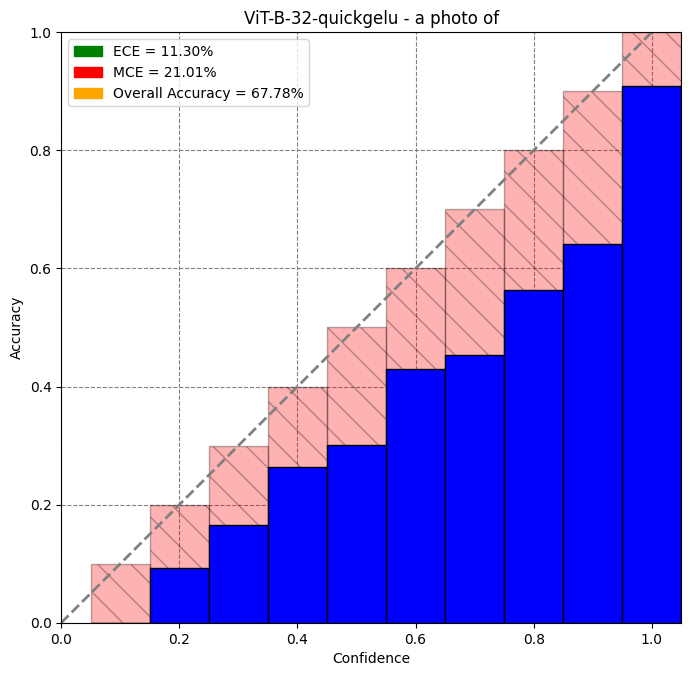

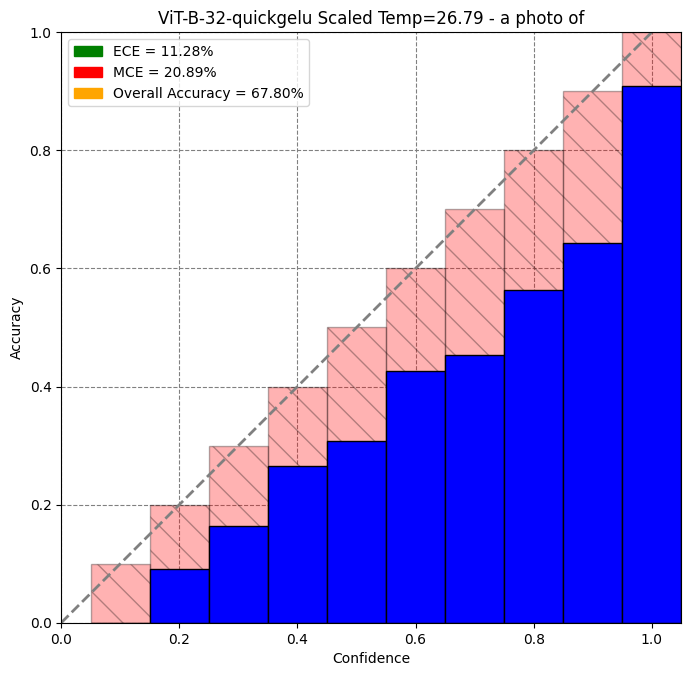

In [36]:
text_to_append = 'a photo of'
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

In [10]:
model_name = 'ViT-bigG-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion2b_s39b_b160k', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)


text_to_append = ''
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
cifar_val = get_val_set(preprocess)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

Downloading:  71%|███████   | 7.20G/10.2G [04:01<02:01, 24.5MB/s] 